# Imports

In [1]:
import os
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skewnorm
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.pipeline import make_pipeline, Pipeline

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as PipelineImb

# Data

In [2]:
def loadAndSplitData(filePath="datasets/updated/txid10376_dataset.csv"): # txid10376 is EBV
    epi = pd.read_csv(filePath)
    epiSplit = epi.loc[epi['Info_split']  == 'split_01_75']
    epiSplit25 = epi.loc[epi['Info_split']  == 'split_02_25']

    return epiSplit, epiSplit25

## Read Data

In [3]:
%matplotlib inline
epi = pd.read_csv("datasets/updated/txid10376_dataset.csv") # txid10376 is EBV

C:\Users\Jorge\AppData\Local\Temp\ipykernel_11880\2589365341.py:2: DtypeWarning: Columns (5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  epi = pd.read_csv("datasets/updated/txid10376_dataset.csv") # txid10376 is EBV


In [4]:
epi.iloc[0:10, :15]

,Info_PepID,Info_organism_id,Info_protein_id,Info_pos,Info_AA,Info_pubmed_id,Info_epitope_id,Info_host_id,Info_nPos,Info_nNeg,Info_type,Info_window,Info_cluster,Info_split,Class
0,Q3KSS4.1:6,10376,Q3KSS4.1,84,G,28604802,"694933,694524",9606,"2,0","0,2",Epitope containing region/antigenic site,PSCIGCKGAHGGTGS,1,split_02_25,-1
1,Q3KSS4.1:6,10376,Q3KSS4.1,85,A,28604802,"694933,694524",9606,"2,0","0,2",Epitope containing region/antigenic site,SCIGCKGAHGGTGSG,1,split_02_25,-1
2,Q3KSS4.1:6,10376,Q3KSS4.1,86,H,28604802,"694933,694524",9606,"2,0","0,2",Epitope containing region/antigenic site,CIGCKGAHGGTGSGA,1,split_02_25,-1
3,Q3KSS4.1:6,10376,Q3KSS4.1,87,G,28604802,"694933,694524",9606,"2,0","0,2",Epitope containing region/antigenic site,IGCKGAHGGTGSGAG,1,split_02_25,-1
4,Q3KSS4.1:6,10376,Q3KSS4.1,88,G,28604802,"694933,694524,694789",9606,"2,0,0","0,2,2",Epitope containing region/antigenic site,GCKGAHGGTGSGAGA,1,split_02_25,-1
5,Q3KSS4.1:6,10376,Q3KSS4.1,89,T,28604802,"694933,694524,694789",9606,"2,0,0","0,2,2",Epitope containing region/antigenic site,CKGAHGGTGSGAGAG,1,split_02_25,-1
6,Q3KSS4.1:6,10376,Q3KSS4.1,90,G,28604802,"694933,694524,694789",9606,"2,0,0","0,2,2",Epitope containing region/antigenic site,KGAHGGTGSGAGAGG,1,split_02_25,-1
7,Q3KSS4.1:6,10376,Q3KSS4.1,91,S,28604802,"694933,694524,694789",9606,"2,0,0","0,2,2",Epitope containing region/antigenic site,GAHGGTGSGAGAGGA,1,split_02_25,-1
8,Q3KSS4.1:6,10376,Q3KSS4.1,92,G,28604802,"694933,694524,694789",9606,"2,0,0","0,2,2",Epitope containing region/antigenic site,AHGGTGSGAGAGGAG,1,split_02_25,-1
9,Q3KSS4.1:6,10376,Q3KSS4.1,93,A,28604802,"694933,694524,694789",9606,"2,0,0","0,2,2",Epitope containing region/antigenic site,HGGTGSGAGAGGAGA,1,split_02_25,-1


In [5]:
# Info_pubmed_id col 5
pubmed = epi.iloc[:, 5] 

# Info_host_id col 7
host = epi.iloc[:, 7]

pubmed.value_counts()

28604802                                               10429
26831522                                                 762
26831522                                                 369
28604802                                                 256
1376768                                                  132
                                                       ...  
2164400,20638898,31787984                                  5
16385527,1372022,7554555,18849143,23379431                 4
20638898,31787984                                          4
16385527,1372022,7554555,18849143,23379431,32808238        3
28604802,30214572                                          1
Name: Info_pubmed_id, Length: 64, dtype: int64

## Split Data

In [6]:
# rows have predetermined test and train splits based off 'Info_split' column.
epiSplit = epi.loc[epi['Info_split']  == 'split_01_75']
epiSplit25 = epi.loc[epi['Info_split']  == 'split_02_25']

# Exploratory Data Analysis


## Separate Feature + Class/Info

In [7]:
# all feat columns
# first 15 cols is info_* + Class. last col is txid
# split off info_* + txid, keep class
epiInfo = epiSplit.iloc[:, :15]
epiFeat = epiSplit.iloc[:, 15:-1]

#epiFeat = pd.DataFrame(epiSplit)
#for k in epiFeat: # strip columns that aren't features, (which are info_* & txid)
#    if k[0:4] == "Info" or k == "txid":
#        del epiFeat[k]

## Missing Data

In [8]:
epiFeat.isnull().sum().sum()

0

## Data Types

In [9]:
print(f'Full Split\n{epiSplit.dtypes.value_counts()}\n')

print(f'Features only\n{epiFeat.dtypes.value_counts()}')

Full Split
float64    1280
object       11
int64         5
dtype: int64

Features only
float64    1280
dtype: int64


## Data Scale

In [10]:
epiFeatDescribed = epiFeat.describe()
epiFeatDescribed

,feat_esm1b_0,feat_esm1b_1,feat_esm1b_2,feat_esm1b_3,feat_esm1b_4,feat_esm1b_5,feat_esm1b_6,feat_esm1b_7,feat_esm1b_8,feat_esm1b_9,...,feat_esm1b_1270,feat_esm1b_1271,feat_esm1b_1272,feat_esm1b_1273,feat_esm1b_1274,feat_esm1b_1275,feat_esm1b_1276,feat_esm1b_1277,feat_esm1b_1278,feat_esm1b_1279
count,10031.000000,10031.000000,10031.000000,10031.000000,10031.000000,10031.000000,10031.000000,10031.000000,10031.000000,10031.000000,...,10031.000000,10031.000000,10031.000000,10031.000000,10031.000000,10031.000000,10031.000000,10031.000000,10031.000000,10031.000000
mean,0.034977,0.160971,0.033474,0.121187,-0.102944,-0.041334,-0.158055,-0.058347,-0.150542,-0.043892,...,0.168707,-0.054615,-0.090601,0.086166,-0.951790,-0.091915,0.011489,0.013703,-0.024703,0.282374
std,0.179274,0.148874,0.183296,0.144734,0.164503,0.163882,0.182002,0.227524,0.208000,0.156520,...,0.190840,0.176546,0.160519,0.174011,0.443312,0.159961,0.174640,0.152910,0.185377,0.190443
min,-0.600373,-0.594108,-0.806463,-0.673566,-0.994124,-0.849109,-1.150828,-1.005215,-1.054126,-0.890890,...,-0.434479,-0.719619,-1.216068,-0.673498,-2.173906,-0.650296,-0.778795,-0.849919,-0.737851,-0.880770
25%,-0.081617,0.063556,-0.085833,0.028781,-0.210134,-0.152507,-0.263806,-0.214737,-0.261926,-0.138111,...,0.037890,-0.180069,-0.195320,-0.016961,-1.239038,-0.196847,-0.098135,-0.073767,-0.145512,0.163220
50%,0.025262,0.158487,0.033272,0.124130,-0.102541,-0.040915,-0.146388,-0.068768,-0.141506,-0.035893,...,0.154026,-0.057614,-0.093921,0.085615,-1.001286,-0.090839,0.017312,0.025574,-0.014891,0.282695
75%,0.143315,0.256612,0.151264,0.217502,0.006746,0.073372,-0.037115,0.101466,-0.019916,0.060278,...,0.288296,0.066530,0.016897,0.181705,-0.726972,0.009749,0.127379,0.112611,0.100964,0.404480
max,0.723302,0.883082,0.807788,0.711804,0.618355,0.612200,0.447342,0.945723,0.527893,0.487205,...,1.089013,0.659692,0.682786,1.030231,1.230547,0.761848,0.795452,0.559261,0.766222,0.977553


In [11]:
maxVal = epiFeatDescribed.loc['max']
#epiFeat["feat_esm1b_450 "] # "feat_esm1b_450"
minVal = epiFeatDescribed.loc['min']
sdVal = epiFeatDescribed.loc['std']

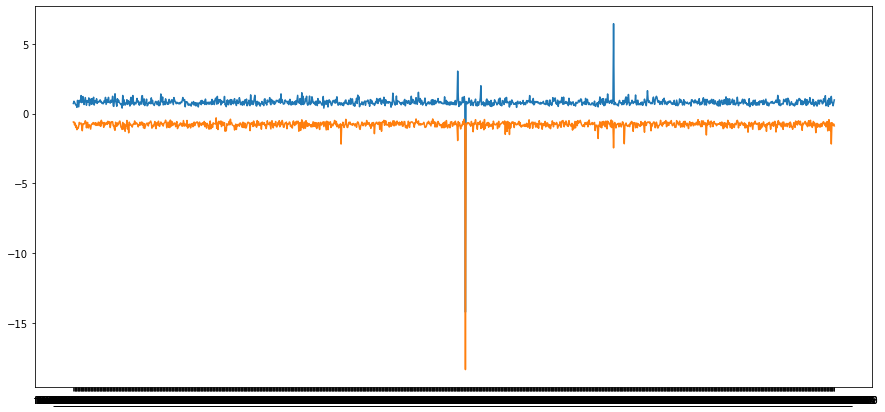

In [12]:
plt.figure(figsize=(15, 7))
# most data stays within reasonable bounds
plt.plot(maxVal)
plt.plot(minVal)
#plt.plot(sdVal)

In [13]:
sdValOutlier = sdVal[sdVal > sdVal.describe[] ]
sdValOutlier

SyntaxError: invalid syntax (3336473575.py, line 1)

<AxesSubplot:xlabel='feat_esm1b_646 ', ylabel='Count'>

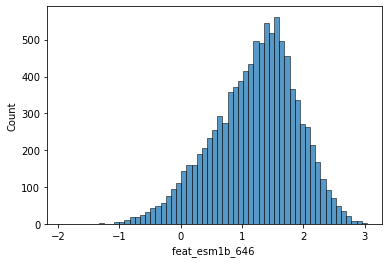

In [ ]:
# feat_esm1b_646 - large s.d
sns.histplot(epiFeat['feat_esm1b_646 '])

<AxesSubplot:xlabel='feat_esm1b_1274', ylabel='Count'>

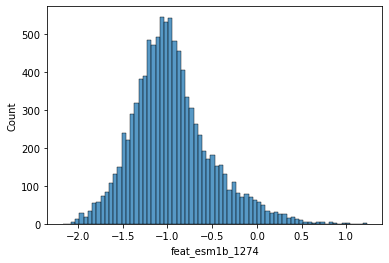

In [ ]:
# feat_esm1b_1274 - large s.d
sns.histplot(epiFeat['feat_esm1b_1274'])

<AxesSubplot:xlabel='feat_esm1b_908 ', ylabel='Count'>

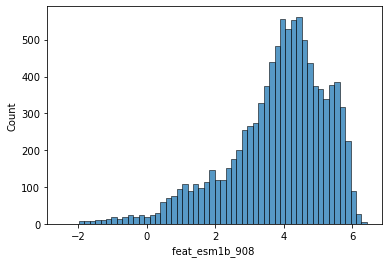

In [ ]:
# feat_esm1b_908 - abnormally high max value + large s.d
maxVal[maxVal > 5]
sns.histplot(epiFeat['feat_esm1b_908 '])

<AxesSubplot:xlabel='feat_esm1b_659 ', ylabel='Count'>

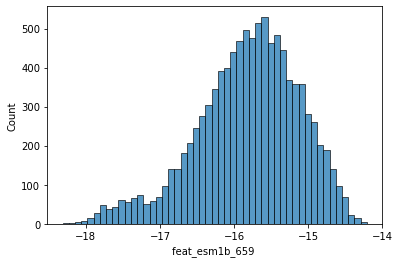

In [ ]:
# feat_esm1b_659 - abnormally low max and min value
minVal[minVal<-5] # feat_esm1b_659 
maxVal['feat_esm1b_659 '] # also low
sns.histplot(epiFeat['feat_esm1b_659 '])

## Class Balance

In [ ]:
epiPos = epiFeat.loc[epiInfo['Class'] == -1] # only features which are epitope positive
epiNeg = epiFeat.loc[epiInfo['Class'] == 1]

In [ ]:
# Class Distribution
posPcnt = len(epiPos) / (len(epiPos) + len(epiNeg))
print(f'% Positive: {posPcnt}\n% Negative: {1 - posPcnt}')

% Positive: 0.6770012959824544
% Negative: 0.3229987040175456


## Outliers - Skew

Checks for outliers as will affect skewness

[Text(0.5, 0, '')]

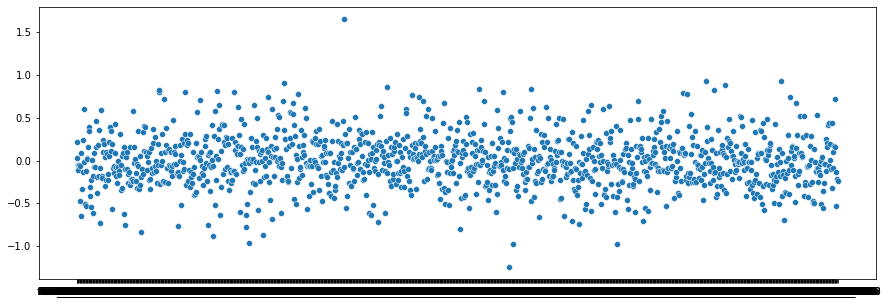

In [ ]:
skew = epiFeat.skew(axis = 0)
plt.figure(figsize=(15, 5))
sns.scatterplot(data=skew).set(xlabel=None)

#plt.xlabel('Skew')
#plt.figure(figsize=(15, 7))

<AxesSubplot:xlabel='feat_esm1b_450 ', ylabel='Count'>

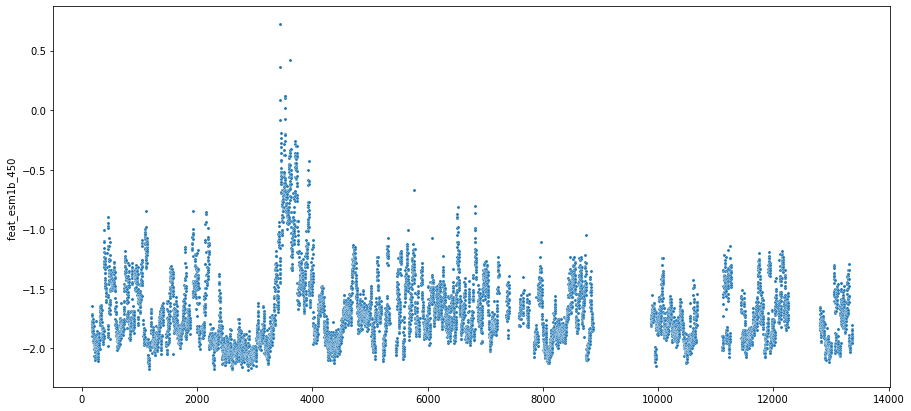

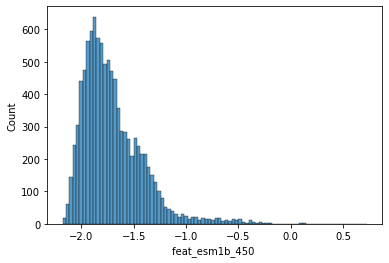

In [ ]:
plt.figure(figsize=(15, 7))

highSkew = skew[abs(skew) > 1.5] # only column is feat_ESM1b_450 (updated - feat_esm1b_450)
sns.scatterplot(data = epiFeat["feat_esm1b_450 "], s=10)
plt.figure()
sns.histplot(epiFeat['feat_esm1b_450 '])

## Outliers - IQR

In [ ]:
epiFeat25Q = epiFeatDescribed.loc['25%']
epiFeat75Q = epiFeatDescribed.loc['75%']
epiFeatIQR = epiFeat75Q - epiFeat25Q

outlier = pd.DataFrame()
o = []

for col in epiFeat.columns:
    lower = epiFeat25Q[col] - (1.5 * epiFeatIQR[col])
    upper = epiFeat75Q[col] + (1.5 * epiFeatIQR[col])
    e = epiFeat[col]
    mask = ((e > upper)| (e < lower))
    eoutlier = epiFeat[col][mask]

    o.append(eoutlier)

    #outlier.add(eoutlier)
    #print(eoutlier)
    #e = epiFeat[col > upper] | epiFeat[col < lower]

In [ ]:
len(o)

1280

## Variance

In [ ]:
epiFeatVar = epiFeat.var()

epiFeatVar[epiFeatVar > 0.5]

feat_esm1b_908     2.077347
dtype: float64

<AxesSubplot:>

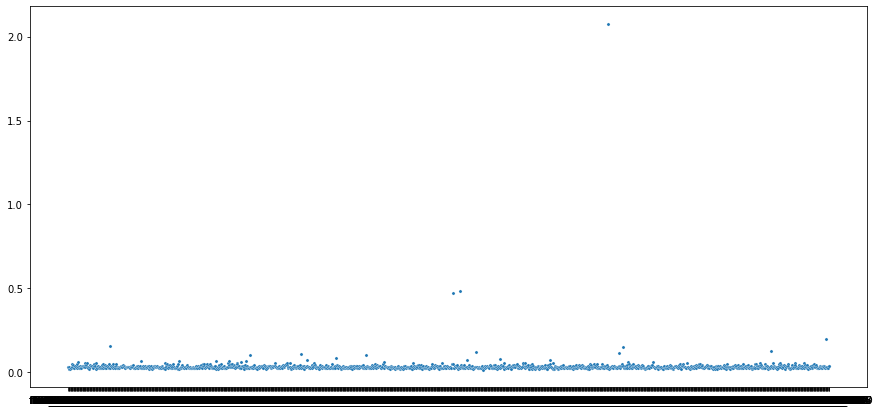

In [ ]:
plt.figure(figsize=(15, 7))
sns.scatterplot(data = epiFeatVar, s=10)

## Visualisation - t-SNE

In [ ]:
tsne = TSNE(2) # number of components

In [ ]:
tsnePosRes = tsne.fit_transform(epiPos)
tsneNegRes = tsne.fit_transform(epiNeg)

c:\Users\Jorge\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Jorge\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\Jorge\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Jorge\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

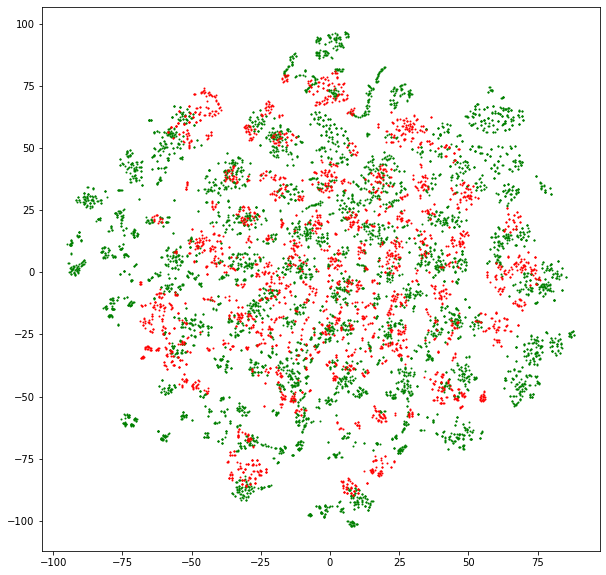

<Figure size 432x288 with 0 Axes>

In [ ]:
xPos = [pair[0] for pair in tsnePosRes]
yPos = [pair[1] for pair in tsnePosRes]

xNeg = [pair[0] for pair in tsneNegRes]
yNeg = [pair[1] for pair in tsneNegRes]

plt.figure(figsize=(10, 10))
plt.scatter(xPos, yPos, 1, c='Green')
plt.scatter(xNeg, yNeg, 1, c='Red')
plt.figure()

# Pre-Processing

In [ ]:
epiSplitPP = pd.DataFrame(epiSplit)  # full dataset
epiFeatPP = pd.DataFrame(epiSplit.iloc[:, 0:15]) 
epiInfoPP = pd.DataFrame(epiSplit.iloc[:, 15:-1])

,feat_esm1b_0,feat_esm1b_1,feat_esm1b_2,feat_esm1b_3,feat_esm1b_4,feat_esm1b_5,feat_esm1b_6,feat_esm1b_7,feat_esm1b_8,feat_esm1b_9,...,feat_esm1b_1270,feat_esm1b_1271,feat_esm1b_1272,feat_esm1b_1273,feat_esm1b_1274,feat_esm1b_1275,feat_esm1b_1276,feat_esm1b_1277,feat_esm1b_1278,feat_esm1b_1279
167,0.068227,-0.097183,0.260305,0.184433,-0.037628,0.044536,-0.326648,0.044726,-0.193410,0.018526,...,0.022815,-0.179518,-0.038173,0.143409,-0.055990,-0.116945,-0.338596,-0.078049,-0.202369,-0.273914
168,0.196930,-0.340547,0.283295,0.215414,-0.260338,-0.085275,-0.456092,-0.172831,0.205739,-0.121767,...,0.197536,-0.219553,-0.137543,0.139384,-1.479725,-0.261132,0.041565,-0.396369,0.052719,0.076499
169,0.113100,-0.229330,0.133169,0.173850,-0.072224,0.115014,-0.253163,-0.285672,0.026630,-0.102702,...,0.334023,-0.293509,-0.270296,0.176450,-1.678533,-0.050173,-0.045367,-0.061341,0.008039,0.092027
170,0.152819,-0.230194,0.077652,0.161104,-0.024962,-0.007805,-0.218216,-0.362453,-0.003955,-0.130677,...,0.302079,-0.352365,-0.241299,0.183049,-1.520374,-0.149068,0.020389,-0.085354,0.200157,0.142704
171,0.141979,-0.004518,0.101570,0.287460,0.171255,0.064568,-0.330510,0.067368,-0.020897,-0.182489,...,0.315847,-0.174357,-0.245640,0.066300,-1.604958,-0.093904,0.193334,-0.118600,0.211741,0.220367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13370,0.258892,0.278007,-0.086563,0.170392,-0.099858,0.002465,-0.397437,-0.289127,-0.253695,0.151391,...,-0.074809,-0.006571,0.171104,-0.234149,-0.559116,-0.095630,0.184087,0.038263,-0.008138,0.154345
13371,-0.028697,0.241093,-0.337201,0.231371,-0.086707,-0.110211,-0.139586,0.202734,0.013437,0.026431,...,-0.087264,0.057521,-0.101252,0.157061,-1.188527,-0.157200,0.125286,-0.074456,-0.121075,0.114511
13372,0.118019,0.236254,0.060418,-0.076337,-0.046708,-0.080748,-0.257387,-0.186056,0.060003,0.187307,...,-0.244319,0.045033,0.110210,0.166316,-1.485936,-0.036392,0.002033,0.140833,0.210665,0.178675
13373,-0.010269,0.203631,-0.028499,0.314025,-0.073183,0.077898,-0.402333,0.085654,-0.042786,-0.038047,...,0.000716,0.025110,-0.282360,-0.069427,-1.290098,-0.115747,0.146300,0.046811,0.114688,0.295623


## Class Rebalancing: Random Undersampling

In [ ]:
randUS = RandomUnderSampler(random_state=0)
X = epiSplitPP
y = epiSplit['Class']
y.value_counts()

-1    6791
 1    3240
Name: Class, dtype: int64

In [ ]:
Xsample, ysample = randUS.fit_resample(X, y)
#epiPosResample, epiNegResample = randUS.sample(epiPos, epiNeg)
ysample.value_counts()

-1    3240
 1    3240
Name: Class, dtype: int64

In [ ]:
epiSplitPP = pd.DataFrame(Xsample)
epiInfoPP = epiSplitPP.iloc[:, 0:15]
epiSplitPP = epiSplitPP.iloc[:, 15:-1]

## Scaling: Min Max Scaler

In [ ]:
scaler = MinMaxScaler() # between 0 and 1
epiFeatPP = pd.DataFrame(scaler.fit(epiFeat).transform(epiFeat), columns = epiFeat.columns)

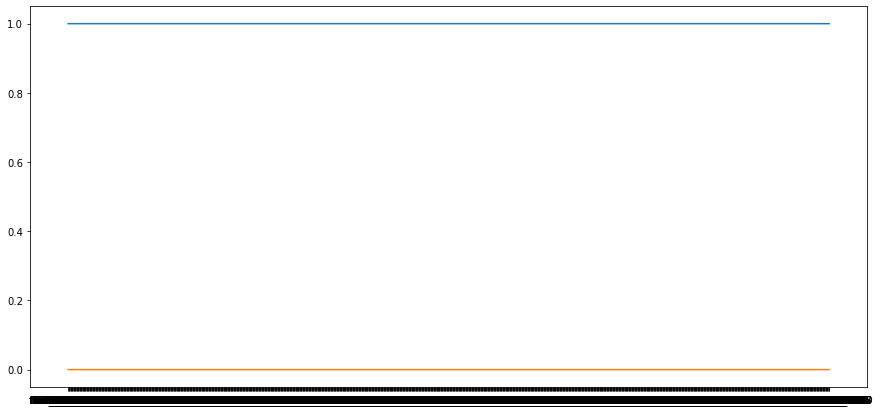

In [ ]:
epiFeatSD = epiFeatPP.describe()
maxVal = epiFeatSD.loc['max']
#epiFeat["feat_esm1b_450 "] # "feat_esm1b_450"
minVal = epiFeatSD.loc['min']

plt.figure(figsize=(15, 7))
plt.plot(maxVal)
plt.plot(minVal)

## [Old] Missing Data - Drop NaN

In [ ]:
#epiFeat = epiFeat.dropna(axis=0) # remove rows (axis=0) containing null data
#epiFeat.dtypes.value_counts()
#epiFeat.isnull().sum().sum()

# Model Fitting and Evaluation

## Data Splits

In [16]:
epiSplit, epiSplit25 = loadAndSplitData() # default to EBV - txid10376

X_train = epiSplit.iloc[:, 15:-1]
y_train = epiSplit['Class']

X_test = epiSplit25.iloc[:, 15:-1]
y_test = epiSplit25['Class']

C:\Users\Jorge\AppData\Local\Temp\ipykernel_11880\1261518452.py:2: DtypeWarning: Columns (5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  epi = pd.read_csv(filePath)


## Pipelines + Model Fit/Predict Functions

In [18]:
# custom transformer using MakeTransformer(function here)
# includes class rebalancing, pre-processing (scaling) + classifer
rfPipeline = PipelineImb([
    ('RandomUndersampler', RandomUnderSampler()),
    ('MinMaxScaler', MinMaxScaler()),
    ('RFClassifier', RandomForestClassifier())
    ])

svmClf = SVC()
svmClf.probability = True  # tells model to provide % probabilites for each class, instead of binary classifications
svmPipeline = PipelineImb([
    ('RandomUndersampler', RandomUnderSampler()),
    ('MinMaxScaler', MinMaxScaler()),
    ('SVMClassifier', svmClf)
    ])

gbPipeline = PipelineImb([
    ('RandomUndersampler', RandomUnderSampler()),
    ('MinMaxScaler', MinMaxScaler()),
    ('GBClassifier', GradientBoostingClassifier())
    ])


# function to encapsulate both fitting and prediction for models.
# returns predictions as array of tuples where tuple = (p(neg),p(pos))
def rfPred():
    rfPipeline.fit(X_train, y_train)
    return rfPipeline.predict_proba(X_test) 

def svmPred():
    svmPipeline.fit(X_train, y_train)
    return svmPipeline.predict_proba(X_test)

def gbPred():
    gbPipeline.fit(X_train, y_train)
    return gbPipeline.predict_proba(X_test)

# dict of functions to access of different models
modelDict = {
    'rf': rfPred,
    'svm': svmPred,
    'gb': gbPred
    }


# single model
def modelPred(model): 
    return modelDict[model]

# all models
def modelpredAll():
    preds = []
    for model, f in modelDict:
        preds.append(model, f())

    return preds

# threshold predition % after model prediction. reduces both model class preds and real class data
def thresholdResult(y_test, y_pred, t=0.5):
    thresholdMask = y_pred > t
    return y_test[thresholdMask], y_pred[thresholdMask]

def getAUCScore(y_test, y_pred):
    return metrics.roc_auc_score(y_test, y_pred)

def thresholdAndGetAUCScore(y_test, y_pred):
    return getAUCScore(*thresholdResult(y_test, y_pred))

def saveModel(fileName, model):
    with open(fileName + '.pkl','wb') as f:
        pickle.dump(model,f)

def loadModel(fileName):
    with open(fileName + '.pkl', 'rb') as f:
        return pickle.load(f)


## Model Fitting + Prediction

In [19]:
y_predSVM = modelPred('svm')()[:, 1]  # returns list of tuples (-1%, 1%). index 1 of tuple is pos %, so get this only
y_predRF = modelPred('rf')()[:, 1]
y_predGB = modelPred('gb')()[:, 1]

<AxesSubplot:>

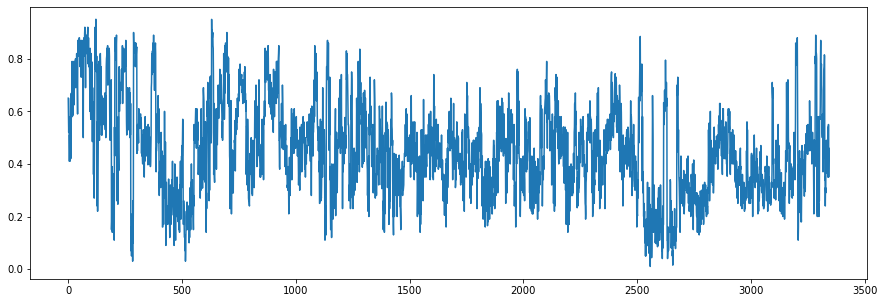

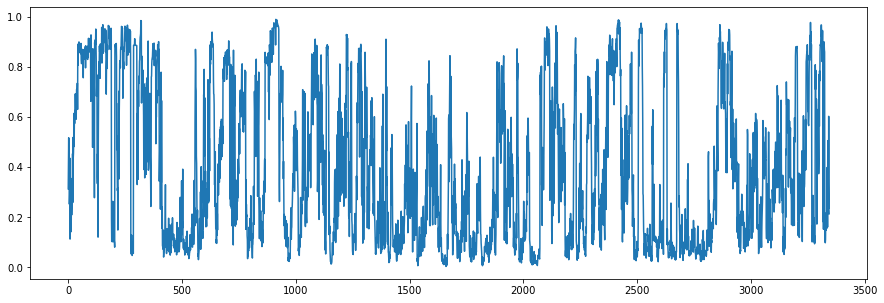

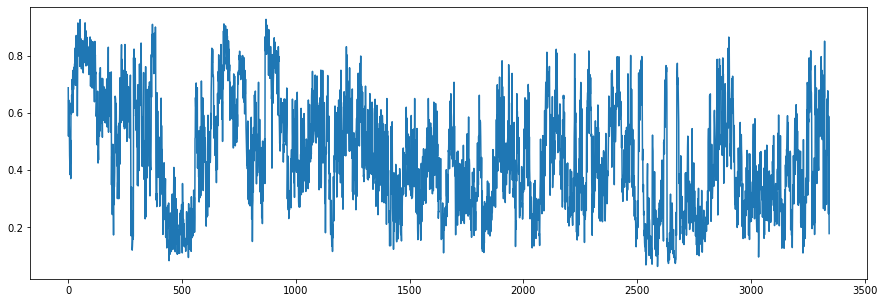

In [47]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=y_predRF)
plt.figure(figsize=(15, 5))
sns.lineplot(data=y_predSVM)
plt.figure(figsize=(15, 5))
sns.lineplot(data=y_predGB)


## Model Evaluation

In [21]:
aucSVM = getAUCScore(y_test, y_predSVM) #thresholdAndGetAUCScore(y_test, y_predSVM)
aucRF = getAUCScore(y_test, y_predRF) #thresholdAndGetAUCScore(y_test, y_predRF)
aucGB = getAUCScore(y_test, y_predGB) #thresholdAndGetAUCScore(y_test, y_predGB)

print(f'SVM AUC Score: {aucSVM}\nRF AUC Score: {aucRF}\nGB AUC Score: {aucGB}')

SVM AUC Score: 0.734500074963496
RF AUC Score: 0.7206436430955361
GB AUC Score: 0.6939486940055276


In [70]:
#y_predRF
print(y_predRF)

[0.51  0.48  0.57  ... 0.355 0.48  0.32 ]
